In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,123 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,431 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,526 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InR

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AirQualityPrediction ") \
    .getOrCreate()


print("Spark initialized:", spark.version)


Spark initialized: 3.5.1


In [3]:
file_path = "/content/drive/MyDrive/finalyear_eng/spark/project/AirQualityUCI.csv"

data = spark.read.csv(file_path, header=True, inferSchema=True, sep=';')
data.show(5)
print(f"Total rows: {data.count()}")


+----------+--------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+----+----+
|      Date|    Time|CO(GT)|PT08.S1(CO)|NMHC(GT)|C6H6(GT)|PT08.S2(NMHC)|NOx(GT)|PT08.S3(NOx)|NO2(GT)|PT08.S4(NO2)|PT08.S5(O3)|   T|  RH|    AH|_c15|_c16|
+----------+--------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+----+----+
|10/03/2004|18.00.00|   2,6|       1360|     150|    11,9|         1046|    166|        1056|    113|        1692|       1268|13,6|48,9|0,7578|NULL|NULL|
|10/03/2004|19.00.00|     2|       1292|     112|     9,4|          955|    103|        1174|     92|        1559|        972|13,3|47,7|0,7255|NULL|NULL|
|10/03/2004|20.00.00|   2,2|       1402|      88|     9,0|          939|    131|        1140|    114|        1555|       1074|11,9|54,0|0,7502|NULL|NULL|
|10/03/2004|21.00.00|   2,2|       1376|      80|     9,2|          948|    

# **Data Cleaning**

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import DoubleType

# Load data
data = spark.read.option("header", True).option("sep", ";").csv("/content/drive/MyDrive/finalyear_eng/spark/project/AirQualityUCI.csv")

# Rename columns safely using toDF()
clean_cols = [c.replace('.', '_').replace('(', '').replace(')', '').replace(' ', '_') for c in data.columns]
data = data.toDF(*clean_cols)

# Drop unnamed or extra columns
data = data.select([c for c in data.columns if not c.startswith("_c")])

# Replace commas with dots and cast to DoubleType
for c in data.columns:
    if c not in ["Date", "Time"]:
        data = data.withColumn(c, regexp_replace(col(c), ",", "."))
        data = data.withColumn(c, col(c).cast(DoubleType()))

# Replace -200 with null (missing sensor values)
for c in data.columns:
    if c not in ["Date", "Time"]:
        data = data.withColumn(c, when(col(c) == -200, None).otherwise(col(c)))

# Drop rows with null target (CO_GT)
data = data.dropna(subset=["COGT"])

# Show schema and preview
data.printSchema()
data.show(5)


root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- COGT: double (nullable = true)
 |-- PT08_S1CO: double (nullable = true)
 |-- NMHCGT: double (nullable = true)
 |-- C6H6GT: double (nullable = true)
 |-- PT08_S2NMHC: double (nullable = true)
 |-- NOxGT: double (nullable = true)
 |-- PT08_S3NOx: double (nullable = true)
 |-- NO2GT: double (nullable = true)
 |-- PT08_S4NO2: double (nullable = true)
 |-- PT08_S5O3: double (nullable = true)
 |-- T: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- AH: double (nullable = true)

+----------+--------+----+---------+------+------+-----------+-----+----------+-----+----------+---------+----+----+------+
|      Date|    Time|COGT|PT08_S1CO|NMHCGT|C6H6GT|PT08_S2NMHC|NOxGT|PT08_S3NOx|NO2GT|PT08_S4NO2|PT08_S5O3|   T|  RH|    AH|
+----------+--------+----+---------+------+------+-----------+-----+----------+-----+----------+---------+----+----+------+
|10/03/2004|18.00.00| 2.6|   1360.0| 150.0|  11.9|    

# **Date/Time and Feature Engineering**

In [8]:
from pyspark.sql.functions import concat_ws, to_timestamp, hour, dayofweek, month

data = data.withColumn("datetime", to_timestamp(concat_ws(' ', col("Date"), col("Time")), "dd/MM/yyyy HH.mm.ss"))
data = data.withColumn("hour", hour("datetime"))
data = data.withColumn("day_of_week", dayofweek("datetime"))
data = data.withColumn("month", month("datetime"))

# Drop original Date and Time
df = data.drop("Date", "Time")
df.show(5)


+----+---------+------+------+-----------+-----+----------+-----+----------+---------+----+----+------+-------------------+----+-----------+-----+
|COGT|PT08_S1CO|NMHCGT|C6H6GT|PT08_S2NMHC|NOxGT|PT08_S3NOx|NO2GT|PT08_S4NO2|PT08_S5O3|   T|  RH|    AH|           datetime|hour|day_of_week|month|
+----+---------+------+------+-----------+-----+----------+-----+----------+---------+----+----+------+-------------------+----+-----------+-----+
| 2.6|   1360.0| 150.0|  11.9|     1046.0|166.0|    1056.0|113.0|    1692.0|   1268.0|13.6|48.9|0.7578|2004-03-10 18:00:00|  18|          4|    3|
| 2.0|   1292.0| 112.0|   9.4|      955.0|103.0|    1174.0| 92.0|    1559.0|    972.0|13.3|47.7|0.7255|2004-03-10 19:00:00|  19|          4|    3|
| 2.2|   1402.0|  88.0|   9.0|      939.0|131.0|    1140.0|114.0|    1555.0|   1074.0|11.9|54.0|0.7502|2004-03-10 20:00:00|  20|          4|    3|
| 2.2|   1376.0|  80.0|   9.2|      948.0|172.0|    1092.0|122.0|    1584.0|   1203.0|11.0|60.0|0.7867|2004-03-10 21:0

# **Data Understanding & Visualization**

In [14]:
data.describe().show()


+-------+----------+--------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|      Date|    Time|              COGT|         PT08_S1CO|            NMHCGT|            C6H6GT|      PT08_S2NMHC|             NOxGT|       PT08_S3NOx|             NO2GT|        PT08_S4NO2|         PT08_S5O3|                 T|                RH|                AH|              hour|       day_of_week|             month|
+-------+----------+--------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  c

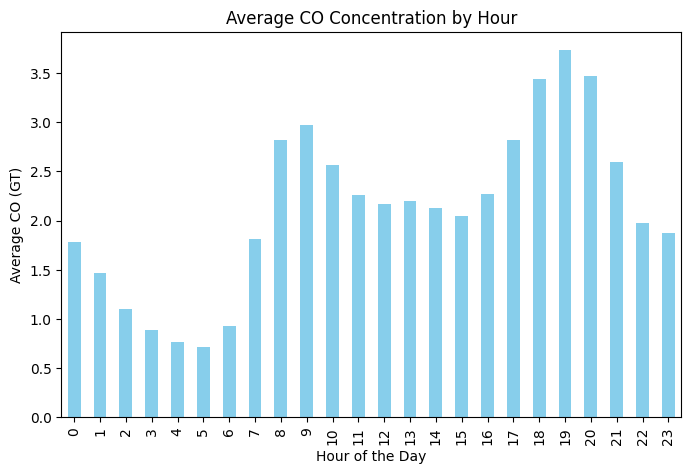

In [13]:
sample = df.select("hour", "COGT").toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sample.groupby("hour")["COGT"].mean().plot(kind="bar", color="skyblue")
plt.title("Average CO Concentration by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average CO (GT)")
plt.show()


**Shows the average pollution level across hours — often peaks occur during traffic hours (morning/evening).**

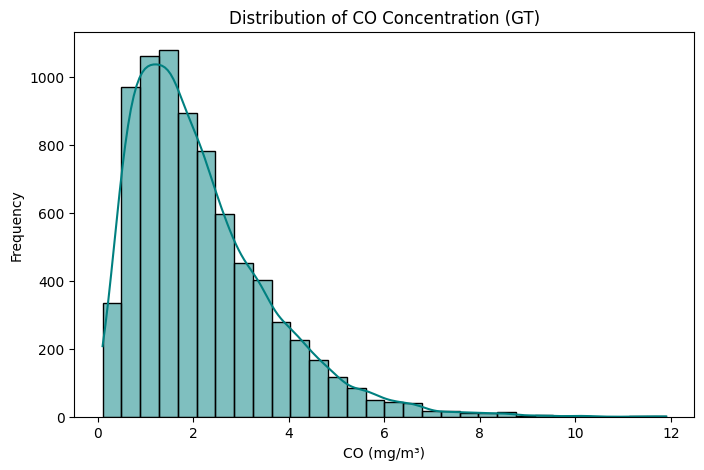

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf = data.select("COGT").toPandas()

plt.figure(figsize=(8,5))
sns.histplot(pdf["COGT"], bins=30, kde=True, color="teal")
plt.title("Distribution of CO Concentration (GT)")
plt.xlabel("CO (mg/m³)")
plt.ylabel("Frequency")
plt.show()


**Shows how carbon monoxide (CO) concentrations are distributed**

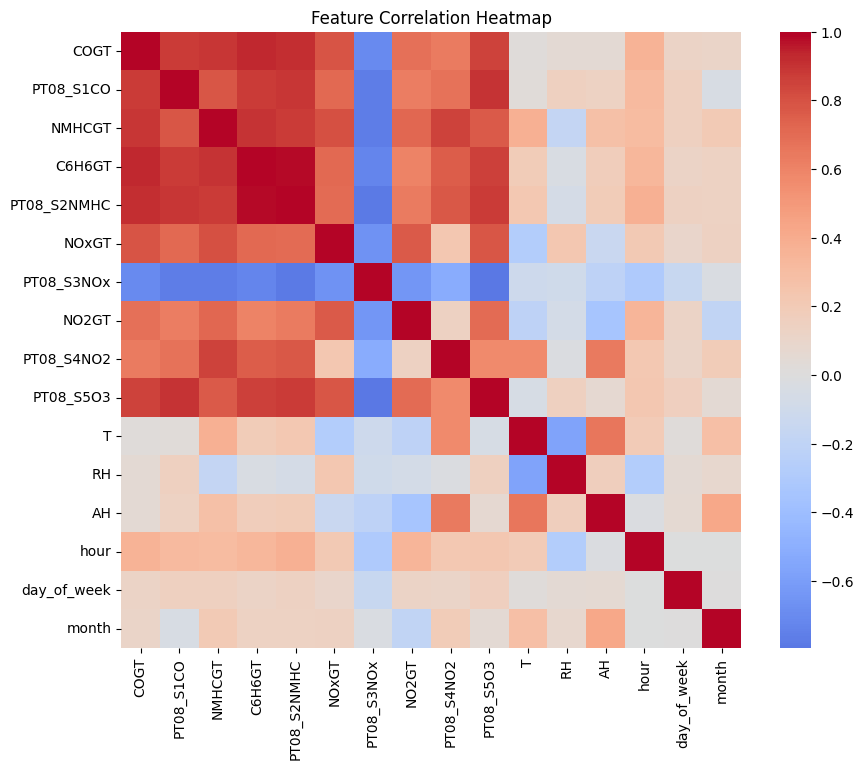

In [16]:
corr_pdf = data.drop("Date", "Time", "datetime").toPandas().corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_pdf, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


**Shows correlations between variables — helps identify redundant or highly related features**

# **Feature Engineering**

In [19]:
from pyspark.sql.functions import col

# Rename target column and clean column names (remove special chars)
for old_name in data.columns:
    new_name = old_name.replace("(", "").replace(")", "").replace(".", "").replace(" ", "")
    data = data.withColumnRenamed(old_name, new_name)

data.printSchema()


root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- COGT: double (nullable = true)
 |-- PT08_S1CO: double (nullable = true)
 |-- NMHCGT: double (nullable = true)
 |-- C6H6GT: double (nullable = true)
 |-- PT08_S2NMHC: double (nullable = true)
 |-- NOxGT: double (nullable = true)
 |-- PT08_S3NOx: double (nullable = true)
 |-- NO2GT: double (nullable = true)
 |-- PT08_S4NO2: double (nullable = true)
 |-- PT08_S5O3: double (nullable = true)
 |-- T: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- AH: double (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)



Drop Nulls & Ensure Numeric Columns

In [21]:
from pyspark.sql.functions import col

# Drop rows with nulls in important numeric columns
data = data.dropna(subset=["COGT"])

# Cast all numeric columns to DoubleType
from pyspark.sql.types import DoubleType

for c in data.columns:
    if c not in ["Date", "Time", "datetime"]:
        data = data.withColumn(c, col(c).cast(DoubleType()))


Filter Out Infinite or Corrupted Values

In [22]:
from pyspark.sql.functions import when

for c in data.columns:
    if c not in ["Date", "Time", "datetime"]:
        data = data.withColumn(c, when(col(c) < -100, None).otherwise(col(c)))

data = data.na.drop()


In [23]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

feature_cols = [c for c in data.columns if c not in ["Date", "Time", "datetime", "COGT"]]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

pipeline = Pipeline(stages=[assembler, scaler])
data_prep = pipeline.fit(data).transform(data).select("scaled_features", "COGT")
data_prep.show(5)


+--------------------+----+
|     scaled_features|COGT|
+--------------------+----+
|[5.62408771114498...| 2.6|
|[5.34288332558773...| 2.0|
|[5.79777277281269...| 2.2|
|[5.69025344892316...| 2.2|
|[5.26017615336501...| 1.6|
+--------------------+----+
only showing top 5 rows



# **Train/Test Split**

In [24]:
train_data, test_data = data_prep.randomSplit([0.8, 0.2], seed=42)
print("Training data:", train_data.count())
print("Testing data:", test_data.count())

Training data: 695
Testing data: 132


# **Train Multiple Models**

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor

)
import matplotlib.pyplot as plt
import pandas as pd

models = {
    "Linear Regression": LinearRegression(featuresCol="scaled_features", labelCol="COGT"),
    "Decision Tree": DecisionTreeRegressor(featuresCol="scaled_features", labelCol="COGT", maxDepth=8),
    "Random Forest": RandomForestRegressor(featuresCol="scaled_features", labelCol="COGT", numTrees=100, maxDepth=10),
    "Gradient Boosted Trees": GBTRegressor(featuresCol="scaled_features", labelCol="COGT", maxIter=100)
}

evaluator = RegressionEvaluator(labelCol="COGT", predictionCol="prediction")
results = []

for name, model in models.items():
    print(f" Training {name}...")
    m = model.fit(train_data)
    preds = m.transform(test_data)
    rmse = evaluator.evaluate(preds, {evaluator.metricName: "rmse"})
    r2 = evaluator.evaluate(preds, {evaluator.metricName: "r2"})
    results.append((name, rmse, r2))
    print(f"{name} → RMSE={rmse:.4f}, R²={r2:.4f}")

results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²"])
results_df



 Training Linear Regression...
Linear Regression → RMSE=0.2149, R²=0.9755
 Training Decision Tree...
Decision Tree → RMSE=0.2749, R²=0.9599
 Training Random Forest...
Random Forest → RMSE=0.2367, R²=0.9702
 Training Gradient Boosted Trees...
Gradient Boosted Trees → RMSE=0.2454, R²=0.9680


,Model,RMSE,R²
0,Linear Regression,0.214855,0.975480
1,Decision Tree,0.274892,0.959862
2,Random Forest,0.236712,0.970238
3,Gradient Boosted Trees,0.245363,0.968022


# **Compare Model Performance**

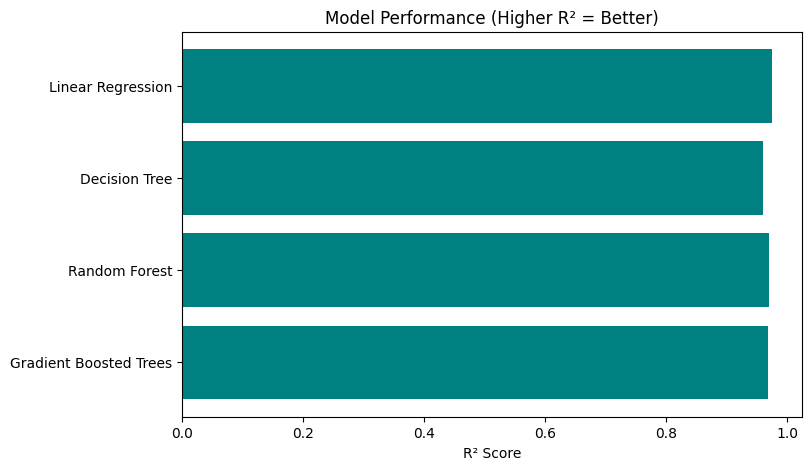

In [27]:
plt.figure(figsize=(8,5))
plt.barh(results_df["Model"], results_df["R²"], color="teal")
plt.title("Model Performance (Higher R² = Better)")
plt.xlabel("R² Score")
plt.gca().invert_yaxis()
plt.show()


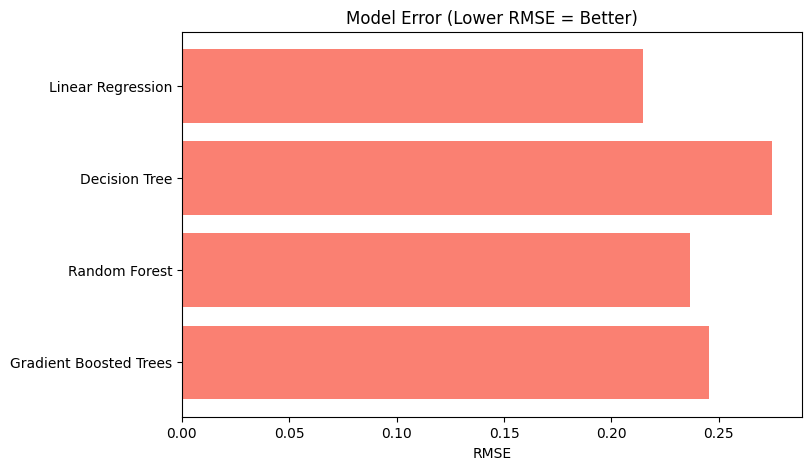

In [28]:
plt.figure(figsize=(8,5))
plt.barh(results_df["Model"], results_df["RMSE"], color="salmon")
plt.title("Model Error (Lower RMSE = Better)")
plt.xlabel("RMSE")
plt.gca().invert_yaxis()
plt.show()

In [29]:
best_model_name = results_df.sort_values(by="R²", ascending=False).iloc[0]["Model"]
print(f"Best Model: {best_model_name}")


Best Model: Linear Regression


In [31]:
best_model = models[best_model_name].fit(train_data)
best_model.save("/content/drive/MyDrive/finalyear_eng/spark/project/air_quality_best_model")

# **Visualize Predictions vs Actual**

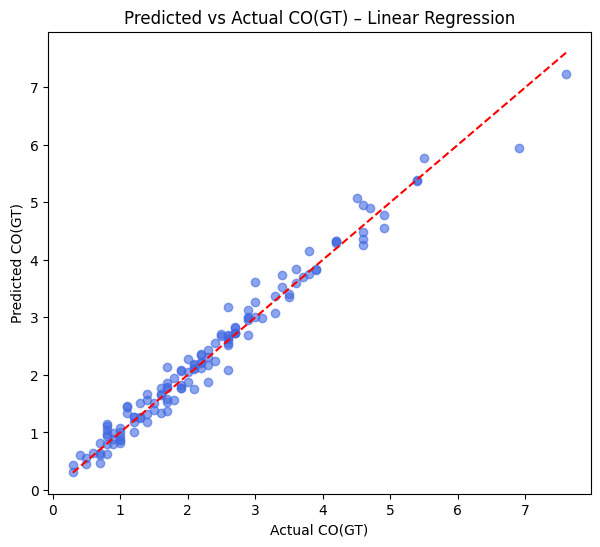

In [33]:
preds = best_model.transform(test_data)
pdf = preds.select("COGT", "prediction").toPandas()

plt.figure(figsize=(7,6))
plt.scatter(pdf["COGT"], pdf["prediction"], alpha=0.6, color="royalblue")
plt.plot([pdf["COGT"].min(), pdf["COGT"].max()],
         [pdf["COGT"].min(), pdf["COGT"].max()],
         color='red', linestyle='--')
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title(f"Predicted vs Actual CO(GT) – {best_model_name}")
plt.show()
